In [38]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Initial distribution not specified, defaulting to")
warnings.filterwarnings("ignore", message="Initial distribution not specified, defaulting to")

In [40]:
# data prepratation
df = pd.read_csv('./data/co2-mm-mlo.csv', parse_dates=['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df['time_idx'] = np.arange(len(df))
df['month'] = df['Date'].dt.month
y = df['Interpolated'].values

In [41]:
# Assume monthly data; last 10 years = 10*12 = 120 months
n_forecast = 10 * 12  
train_df = df.iloc[:-n_forecast]
test_df = df.iloc[-n_forecast:]
y_train = train_df['Interpolated'].values
y_test = test_df['Interpolated'].values

## Simple BSTS

**NOTE: For a more accurate model, scroll to the Local Linear BSTS below.**

This model is intended for initial exploration and understanding of the data. It decomposes the time series using a basic local level (Gaussian random walk) for the trend and a seasonal component with 12 discrete parameters (one per month).  While useful for exploratory analysis, this model does not capture the dynamic evolution of the trend as effectively as the local linear approach.


* Let's first explore and understand the data with simple BSTS.
* This will help appreciate the train and test set seggregation.
* Also, this will help us naturally build to the Local Linear BSTS (below) as a second model.

In [42]:
with pm.Model() as bsts_model:
    sigma_level = pm.HalfNormal("sigma_level", sigma=10.0)
    sigma_obs   = pm.HalfNormal("sigma_obs", sigma=10.0)
    
    mu0 = pm.Normal("mu0", mu=y_train[0], sigma=20.0)
    mu_rw = pm.GaussianRandomWalk("mu_rw", sigma=sigma_level, shape=len(train_df)-1)
    mu = pm.Deterministic("mu", pm.math.concatenate([[mu0], mu0 + pm.math.cumsum(mu_rw)]))
    
    seasonal_raw = pm.Normal("seasonal_raw", mu=0.0, sigma=10.0, shape=12)
    seasonal_effect = pm.Deterministic("seasonal_effect", seasonal_raw - pm.math.mean(seasonal_raw))
    
    month_effect = seasonal_effect[train_df['month'].values - 1]
    
    mu_obs = mu + month_effect
    
    y_obs = pm.Normal("y_obs", mu=mu_obs, sigma=sigma_obs, observed=y_train)
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_level, sigma_obs, mu0, mu_rw, seasonal_raw]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 224 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [43]:
n_steps = n_forecast

posterior = trace.posterior
n_chains, n_draws = posterior["sigma_level"].shape
n_samples = n_chains * n_draws
n_samples

8000

In [44]:
sigma_level_samples = posterior["sigma_level"].values.reshape((n_samples,))
mu_samples = posterior["mu"].values.reshape((n_samples, int(trace.posterior["mu"].shape[-1])))
seasonal_effect_samples = posterior["seasonal_effect"].values.reshape((n_samples, 12))

In [45]:
forecasts = np.empty((n_samples, n_steps))
rng = np.random.default_rng(seed=42)

for i in range(n_samples):
    last_level = mu_samples[i, -1]  # last latent level from training
    sigma = sigma_level_samples[i]
    increments = rng.normal(loc=0, scale=sigma, size=n_steps)
    forecast_level = last_level + np.cumsum(increments)
    forecast_seasonal = seasonal_effect_samples[i, test_df['month'].values - 1]
    forecasts[i, :] = forecast_level + forecast_seasonal


In [46]:
forecast_mean = forecasts.mean(axis=0)
forecast_lower = np.percentile(forecasts, 2.5, axis=0)
forecast_upper = np.percentile(forecasts, 97.5, axis=0)

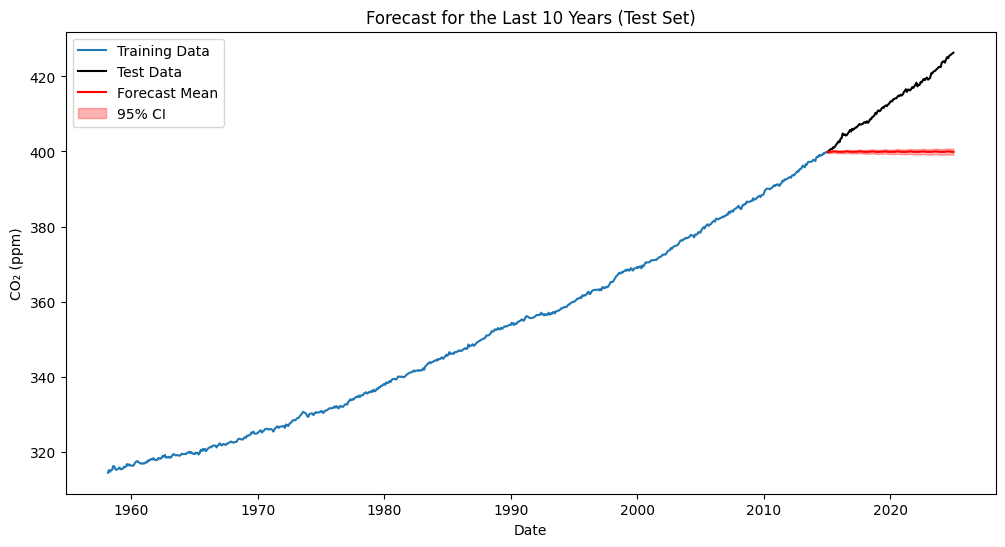

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], y_train, label="Training Data")
plt.plot(test_df['Date'], y_test, label="Test Data", color="black")
plt.plot(test_df['Date'], forecast_mean, label="Forecast Mean", color="red")
plt.fill_between(test_df['Date'], forecast_lower, forecast_upper, color="red", alpha=0.3, label="95% CI")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Forecast for the Last 10 Years (Test Set)")
plt.legend()
plt.show()

## Interpretation

* The large discrepancy between the forecast and the actual test set values is likely due to the model not capturing the strong upward trend in the CO₂ data.
* The latent level is modeled as a random walk (or local level), which assumes that the increments are zero‐mean.
* It’s missing a component (like a drift or a time-varying slope) that accounts for the persistent upward movement in CO₂. This is why the forecast stays nearly flat (or increases very slowly) while the true test data continue to rise substantially.

In [48]:
print(az.summary(trace, var_names=["sigma_level", "sigma_obs", "mu0"]))

                mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_level    0.034  0.004    0.025    0.042      0.000    0.000     179.0   
sigma_obs      0.232  0.008    0.218    0.248      0.000    0.000    1339.0   
mu0          314.769  0.153  314.488  315.061      0.002    0.002    4950.0   

             ess_tail  r_hat  
sigma_level     494.0   1.01  
sigma_obs      3089.0   1.00  
mu0            5548.0   1.00  


Sampling: [y_obs]


Output()

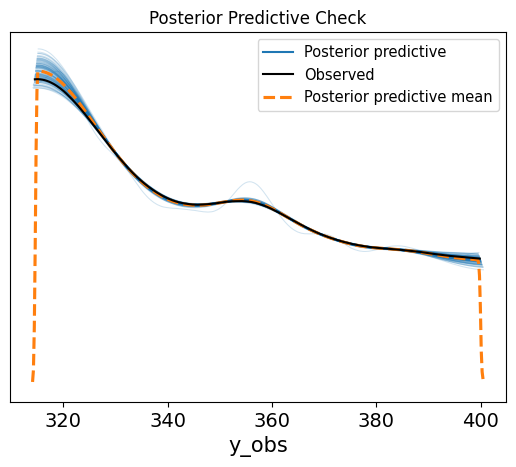

In [49]:
with bsts_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)

az.plot_ppc(ppc, data_pairs={"y_obs": "y_obs"}, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.show()

Text(0.5, 1.0, 'u-value')

/Users/nika/code/kabitalama/MaunaLoa-BSTS-PyMC/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/nika/code/kabitalama/MaunaLoa-BSTS-PyMC/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


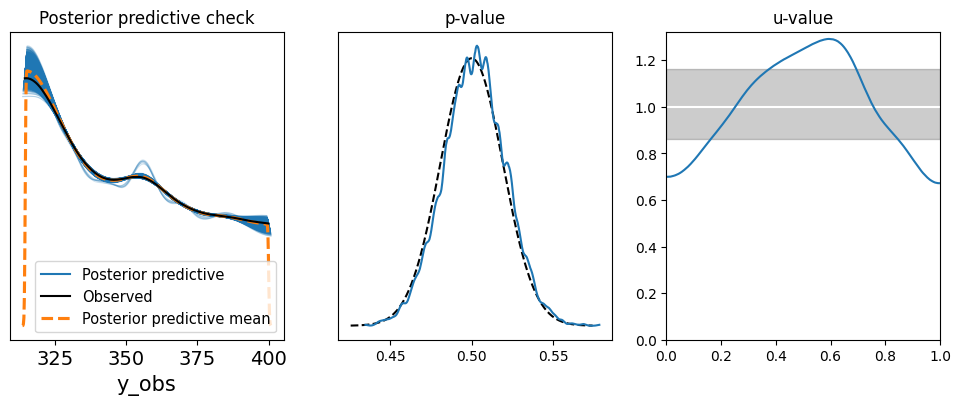

In [50]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
az.plot_ppc(ppc, ax=axs[0])
az.plot_bpv(ppc,  kind="p_value", hdi_prob=0.95, ax=axs[1])
az.plot_bpv(ppc,  kind="u_value", hdi_prob=0.95, ax=axs[2])

axs[0].set_title("Posterior predictive check")
axs[1].set_title("p-value")
axs[2].set_title("u-value")

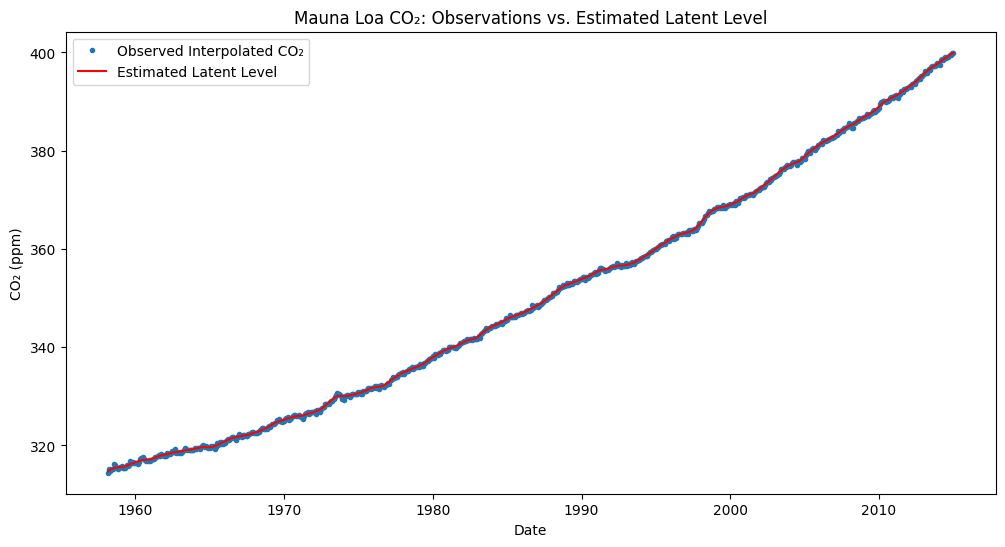

In [51]:
mu_post_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], y_train, 'o', markersize=3, label="Observed Interpolated CO₂")
plt.plot(train_df['Date'], mu_post_mean, label="Estimated Latent Level", color="red")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Mauna Loa CO₂: Observations vs. Estimated Latent Level")
plt.legend()
plt.show()

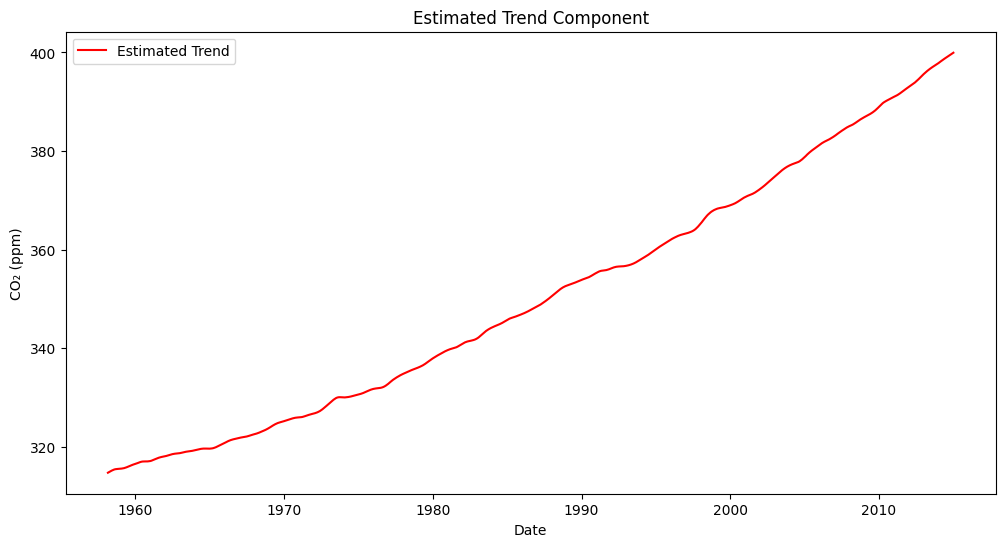

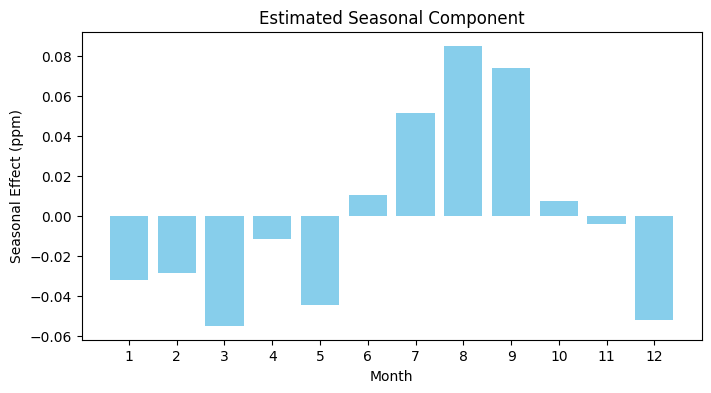

In [52]:
# Extract the posterior mean for the latent trend (mu) and seasonal_effect.
# Here we average over chains and draws.
mu_post_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values
seasonal_effect_mean = trace.posterior["seasonal_effect"].mean(dim=["chain", "draw"]).values

# Plot the latent trend (time-varying component)
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], mu_post_mean, label="Estimated Trend", color="red")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Estimated Trend Component")
plt.legend()
plt.show()

# Plot the seasonal component (one value per month)
plt.figure(figsize=(8, 4))
months = np.arange(1, 13)
plt.bar(months, seasonal_effect_mean, color="skyblue")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect (ppm)")
plt.title("Estimated Seasonal Component")
plt.xticks(months)
plt.show()

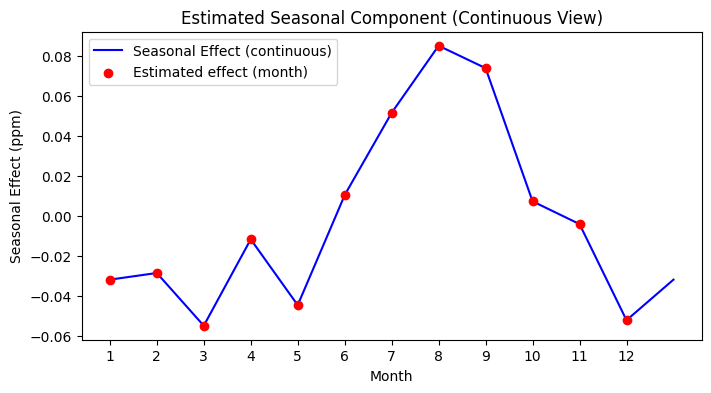

In [53]:
# Extract the posterior mean for the seasonal effect (12 months)
seasonal_effect_mean = trace.posterior["seasonal_effect"].mean(dim=["chain", "draw"]).values

# Create an array of month numbers (1 to 12)
months = np.arange(1, 13)

# For a continuous plot, append the first value at month 13 to complete the cycle.
months_extended = np.append(months, 13)
seasonal_extended = np.append(seasonal_effect_mean, seasonal_effect_mean[0])

# Create a finer grid for a smooth plot
x_fine = np.linspace(1, 13, 200)
seasonal_continuous = np.interp(x_fine, months_extended, seasonal_extended)

plt.figure(figsize=(8, 4))
plt.plot(x_fine, seasonal_continuous, label="Seasonal Effect (continuous)", color="blue")
plt.scatter(months, seasonal_effect_mean, color="red", zorder=5, label="Estimated effect (month)")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect (ppm)")
plt.title("Estimated Seasonal Component (Continuous View)")
plt.xticks(months)
plt.legend()
plt.show()

# BSTS Local Linear

* Here this will help in accurately forecasting the future atmospheric co2 levels.

In [54]:
with pm.Model() as bsts_local_linear:
    sigma_level = pm.HalfNormal("sigma_level", sigma=10.0)
    sigma_slope = pm.HalfNormal("sigma_slope", sigma=1.0)
    sigma_obs   = pm.HalfNormal("sigma_obs", sigma=10.0)
    
    level0 = pm.Normal("level0", mu=y_train[0], sigma=20.0)
    slope0 = pm.Normal("slope0", mu=0.0, sigma=1.0)
    
    rw_slope = pm.GaussianRandomWalk("rw_slope", sigma=sigma_slope, shape=len(train_df)-1)
    slope = pm.Deterministic("slope", pm.math.concatenate([[slope0], rw_slope]))
    
    level = pm.Deterministic("level", level0 + pm.math.cumsum(slope))
    
    seasonal_raw = pm.Normal("seasonal_raw", mu=0.0, sigma=10.0, shape=12)
    seasonal_effect = pm.Deterministic("seasonal_effect", seasonal_raw - pm.math.mean(seasonal_raw))
    
    month_effect = seasonal_effect[train_df['month'].values - 1]
    
    mu_obs = level + month_effect
    
    y_obs = pm.Normal("y_obs", mu=mu_obs, sigma=sigma_obs, observed=y_train)
    
    trace_ll = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_level, sigma_slope, sigma_obs, level0, slope0, rw_slope, seasonal_raw]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 242 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [55]:
n_steps = n_forecast
posterior = trace_ll.posterior
n_chains, n_draws = posterior["sigma_slope"].shape
n_samples = n_chains * n_draws

In [56]:
T_train = len(train_df)
sigma_slope_samples = posterior["sigma_slope"].values.reshape((n_samples,))
sigma_level_samples = posterior["sigma_level"].values.reshape((n_samples,))
level_samples = posterior["level"].values.reshape((n_samples, T_train))
slope_samples = posterior["slope"].values.reshape((n_samples, T_train))
seasonal_effect_samples = posterior["seasonal_effect"].values.reshape((n_samples, 12))

last_level = level_samples[:, -1]
last_slope = slope_samples[:, -1]

for i in range(n_samples):
    t_forecast = np.arange(1, n_steps + 1)
    forecast_level = last_level[i] + last_slope[i] * t_forecast
    forecast_seasonal = seasonal_effect_samples[i, test_df['month'].values - 1]
    forecasts[i, :] = forecast_level + forecast_seasonal

forecast_mean = forecasts.mean(axis=0)
forecast_lower = np.percentile(forecasts, 2.5, axis=0)
forecast_upper = np.percentile(forecasts, 97.5, axis=0)

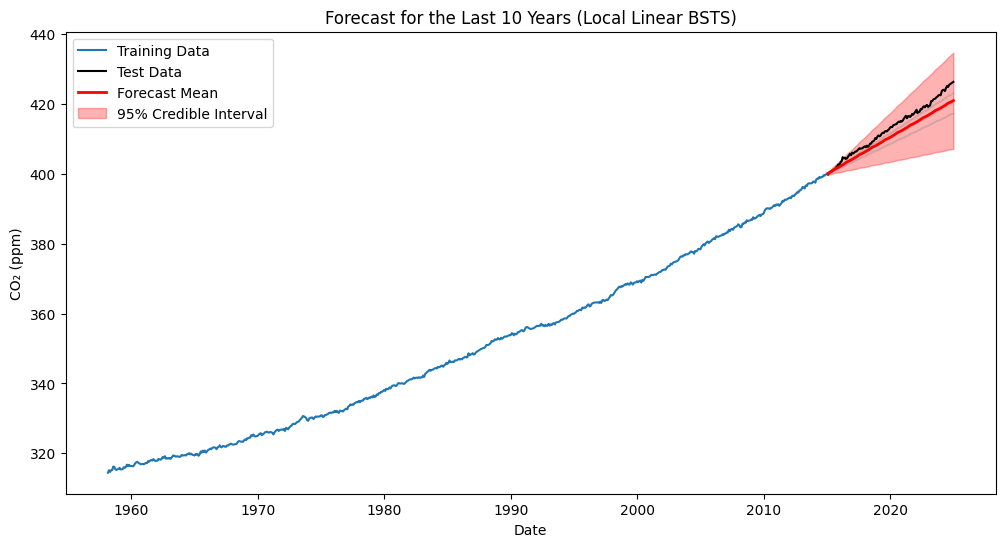

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], y_train, label="Training Data")
plt.plot(test_df['Date'], y_test, label="Test Data", color="black")
n_traj = 3 
sample_indices = np.random.choice(n_samples, size=n_traj, replace=False)
for idx in sample_indices:
    plt.plot(test_df['Date'], forecasts[idx, :], color="gray", alpha=0.3)
plt.plot(test_df['Date'], forecast_mean, label="Forecast Mean", color="red", lw=2)
plt.fill_between(test_df['Date'], forecast_lower, forecast_upper, color="red", alpha=0.3, label="95% Credible Interval")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Forecast for the Last 10 Years (Local Linear BSTS)")
plt.legend()
plt.show()

In [66]:
with bsts_local_linear:
    ppc_ll = pm.sample_posterior_predictive(trace_ll, var_names=["y_obs"], random_seed=42)

Sampling: [y_obs]


Output()

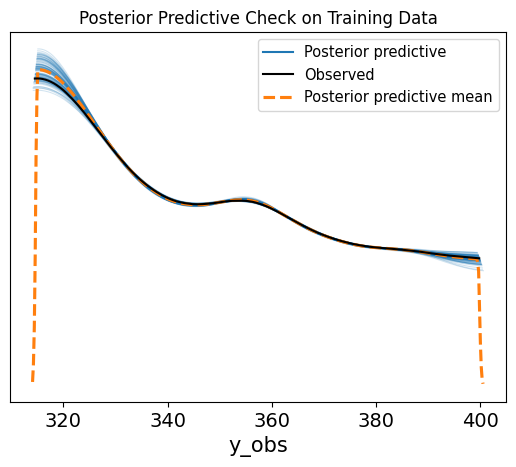

In [67]:
az.plot_ppc(ppc_ll, data_pairs={"y_obs": "y_obs"}, num_pp_samples=100)
plt.title("Posterior Predictive Check on Training Data")
plt.show()

Text(0.5, 1.0, 'u-value')

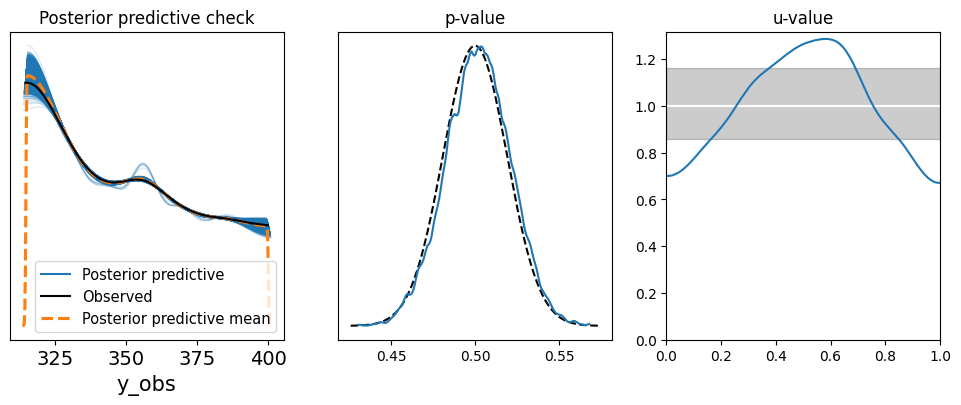

In [69]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
az.plot_ppc(ppc_ll, ax=axs[0])
az.plot_bpv(ppc_ll,  kind="p_value", hdi_prob=0.95, ax=axs[1])
az.plot_bpv(ppc_ll,  kind="u_value", hdi_prob=0.95, ax=axs[2])

axs[0].set_title("Posterior predictive check")
axs[1].set_title("p-value")
axs[2].set_title("u-value")

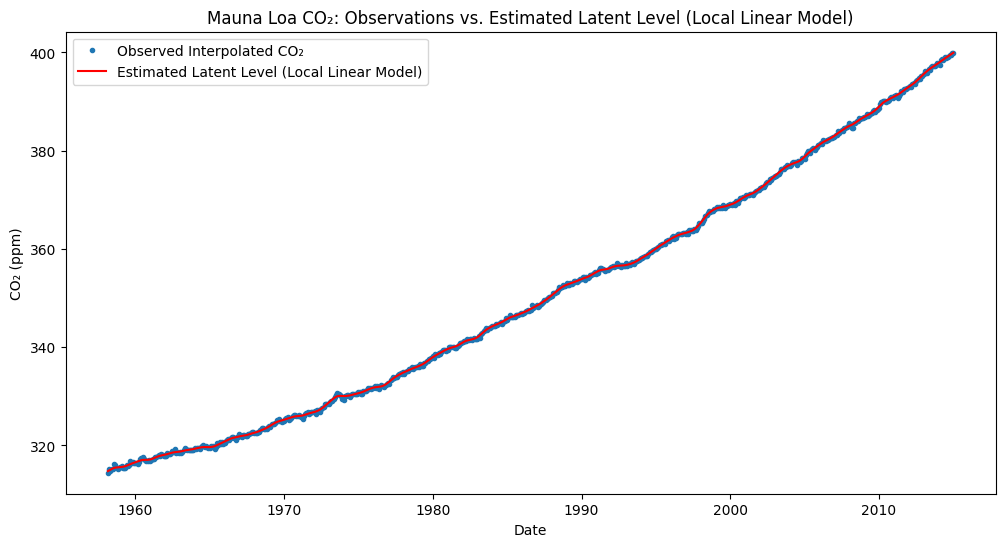

In [70]:
level_post_mean = trace_ll.posterior["level"].mean(dim=["chain", "draw"]).values

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], y_train, 'o', markersize=3, label="Observed Interpolated CO₂")
plt.plot(train_df['Date'], level_post_mean, label="Estimated Latent Level (Local Linear Model)", color="red")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Mauna Loa CO₂: Observations vs. Estimated Latent Level (Local Linear Model)")
plt.legend()
plt.show()

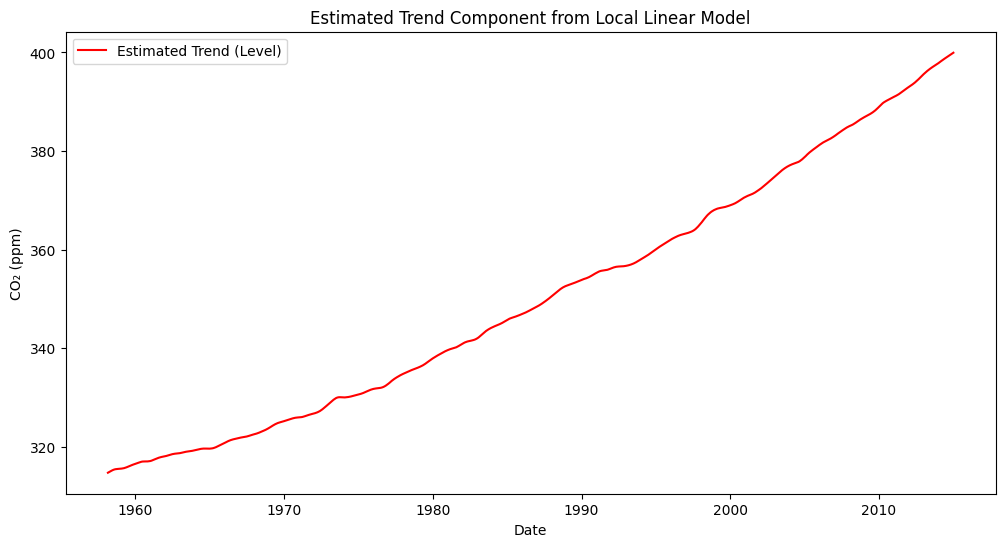

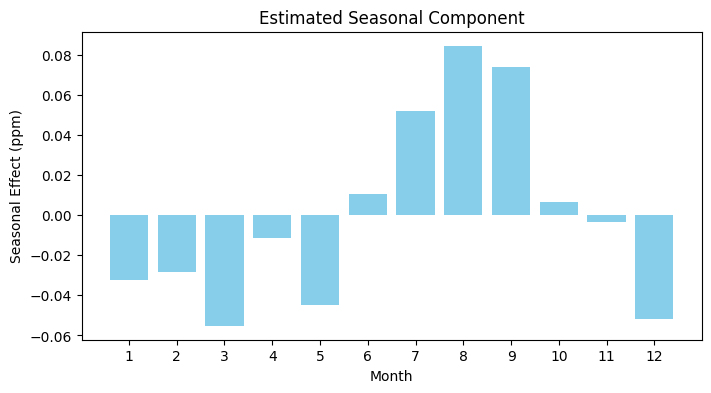

In [71]:
level_post_mean = trace_ll.posterior["level"].mean(dim=["chain", "draw"]).values
seasonal_effect_mean = trace_ll.posterior["seasonal_effect"].mean(dim=["chain", "draw"]).values


plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], level_post_mean, label="Estimated Trend (Level)", color="red")
plt.xlabel("Date")
plt.ylabel("CO₂ (ppm)")
plt.title("Estimated Trend Component from Local Linear Model")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
months = np.arange(1, 13)
plt.bar(months, seasonal_effect_mean, color="skyblue")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect (ppm)")
plt.title("Estimated Seasonal Component")
plt.xticks(months)
plt.show()


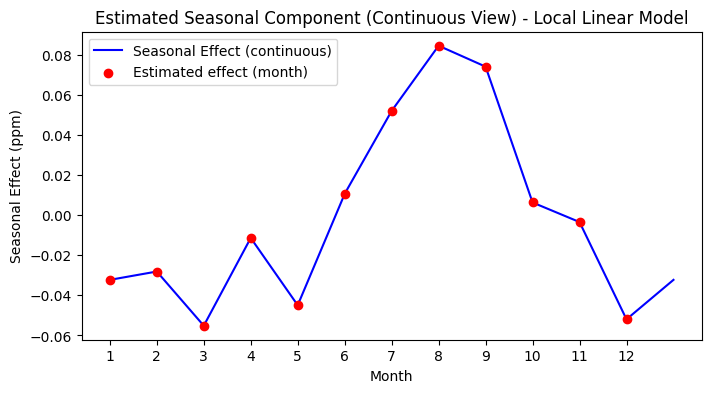

In [72]:
seasonal_effect_mean_ll = trace_ll.posterior["seasonal_effect"].mean(dim=["chain", "draw"]).values
months = np.arange(1, 13)

months_extended = np.append(months, 13)
seasonal_extended = np.append(seasonal_effect_mean_ll, seasonal_effect_mean_ll[0])

x_fine = np.linspace(1, 13, 200)
seasonal_continuous_ll = np.interp(x_fine, months_extended, seasonal_extended)

plt.figure(figsize=(8, 4))
plt.plot(x_fine, seasonal_continuous_ll, label="Seasonal Effect (continuous)", color="blue")
plt.scatter(months, seasonal_effect_mean_ll, color="red", zorder=5, label="Estimated effect (month)")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect (ppm)")
plt.title("Estimated Seasonal Component (Continuous View) - Local Linear Model")
plt.xticks(months)
plt.legend()
plt.show()


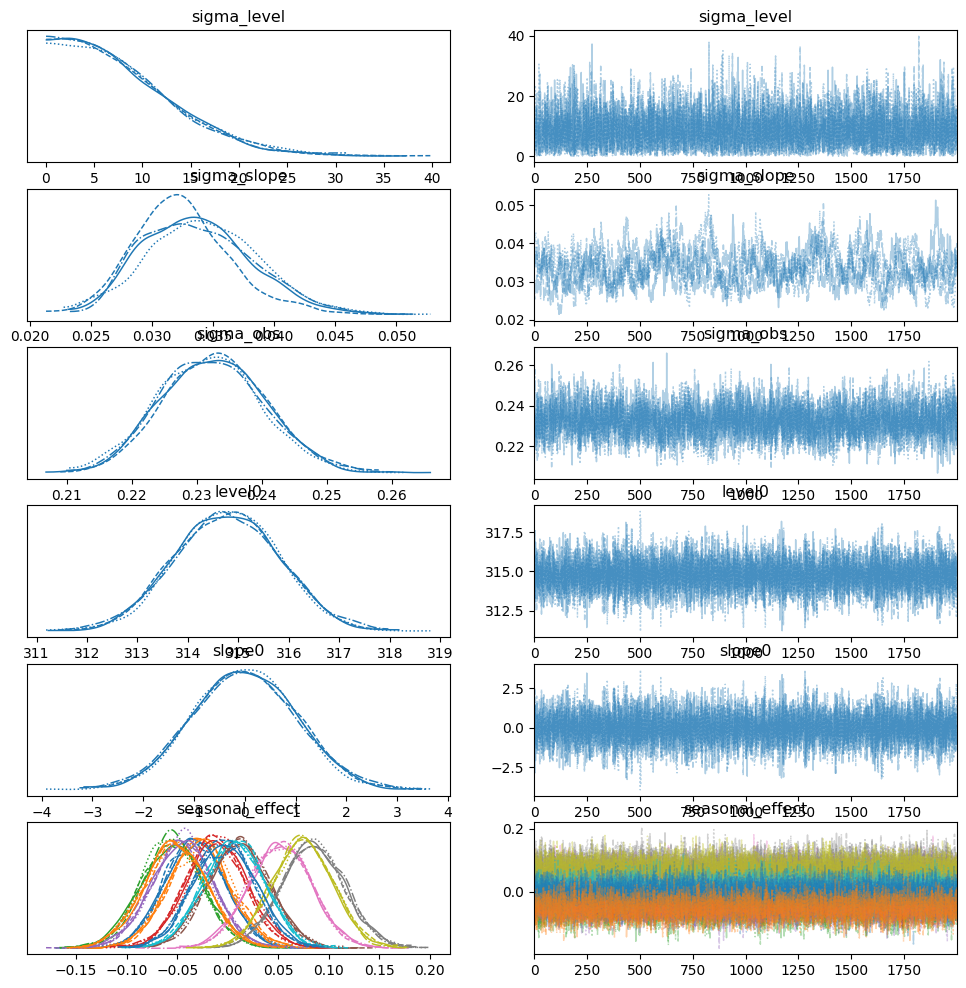

                        mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_level            8.010  5.959    0.005   18.627      0.063    0.074   
sigma_slope            0.034  0.004    0.026    0.042      0.000    0.000   
sigma_obs              0.232  0.008    0.218    0.247      0.000    0.000   
level0               314.779  1.031  312.785  316.619      0.008    0.014   
slope0                -0.009  1.015   -1.970    1.823      0.008    0.014   
seasonal_effect[0]    -0.032  0.030   -0.089    0.022      0.000    0.000   
seasonal_effect[1]    -0.028  0.030   -0.086    0.029      0.000    0.000   
seasonal_effect[2]    -0.055  0.030   -0.111    0.002      0.000    0.000   
seasonal_effect[3]    -0.011  0.030   -0.066    0.047      0.000    0.000   
seasonal_effect[4]    -0.045  0.030   -0.102    0.011      0.000    0.000   
seasonal_effect[5]     0.011  0.031   -0.047    0.068      0.000    0.000   
seasonal_effect[6]     0.052  0.031   -0.007    0.108      0.000    0.000   

In [73]:
az.plot_trace(trace_ll, var_names=["sigma_level", "sigma_slope", "sigma_obs", "level0", "slope0", "seasonal_effect"])
plt.show()
print(az.summary(trace_ll, var_names=["sigma_level", "sigma_slope", "sigma_obs", "level0", "slope0", "seasonal_effect"]))